pip install xlrd

In [1]:
import yfinance as yf
import pandas as pd
import pandas_datareader as pdr
import datetime
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from arch import arch_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

# Extract
## Yahoo Finance

In [2]:
# get s&p 500, nasdaq, dow jones, nikkei, eurostoxx, ftse 100 closing prices & volume

# List of tickers for the indices
tickers = {
    'SP500': '^GSPC',
    'NASDAQ': '^IXIC',
    'DJ': '^DJI',
    'Nikkei': '^N225',
    'Stoxx': '^STOXX50E',
    'FTSE': '^FTSE',
    'Gold': 'GC=F',
    'Silver': 'SI=F',
    'Oil': 'CL=F',
    'Gas': 'NG=F',
    'EUR/USD': 'EURUSD=X',
    'USD/JPY': 'JPY=X',
    'GBP/USD': 'GBPUSD=X',
    'US_10Y': '^TNX',
    'US_2Y': '^IRX',
    'US Corporate Bonds': 'LQD',  # iShares iBoxx $ Investment Grade Corporate Bond ETF
    'US HY Bonds': 'HYG',  # iShares iBoxx $ High Yield Corporate Bond ETF
    'VIX': '^VIX'
}

# Dictionary to store the data
data = {}

for name, ticker in tickers.items():
    index_data = yf.Ticker(ticker).history(period="5y", interval="1d")[["Close", "Volume"]]
    index_data.index = index_data.index.strftime('%Y-%m-%d')
    data[name+'_Close'] = index_data['Close']
    if name not in ['EUR/USD', 'USD/JPY', 'GBP/USD', 'US_10Y', 'US_2Y', 'VIX']:
        data[name+'_Volume'] = index_data['Volume']
    data[name+'_Returns'] = index_data['Close'].pct_change()   #très corrélé avec les log returns
    #data[name+'_Log_Returns'] = np.log(data[name+'_Close']/data[name+'_Close'].shift(1))
    data[name+'_Volatility_20d'] = data[name+'_Returns'].rolling(window=20).std() * np.sqrt(252)


# Convert to DataFrame
df = pd.concat(data.values(), keys=data.keys(), axis=1)
df.index = pd.to_datetime(df.index)

## US interest rates (FRED)

In [3]:
# get interest rates from FRED for the last 5 years
end = datetime.datetime.now()
start = end - datetime.timedelta(days=5*365)

dict_maturities={}
#maturities = [1/12, 0.25, 0.5,1,2,3,5,7,10,20,30]
maturities = [1/12] # très grande corrélation entre les taux donc on en garde qu'un
for i in maturities:
    if(i<1):
        dict_maturities[str(int(i*12))+'M']='DGS'+str(int(i*12))+'MO'
    else:
        dict_maturities[str(i)+'Y']='DGS'+str(i)

data_ir = pd.DataFrame()
for key, series_id in dict_maturities.items():
    data_ir[key] = pdr.get_data_fred(series_id, start, end)
data_ir = data_ir.dropna()/100    #we delete the dates with missing values and convert to percentage

# add CPI data
data_cpi = pdr.get_data_fred('CPIAUCSL', start, end)
data_ir['CPI'] = data_cpi

data_ir.index = pd.to_datetime(data_ir.index)

## Geopolitical events

source : https://www.matteoiacoviello.com/gpr.htm, explanations are in the excel file after the Ith column

| **var_name**   | **var_label**                                  |
|----------------|-----------------------------------------------|
| DAY            | DAY                                           |
| N10D           | Number of articles (10 recent newspapers, 1985-) |
| GPRD           | Daily GPR (Index: 1985:2019=100)              |
| GPRD_ACT       | Daily GPR Acts (Index: 1985:2019=100)         |
| GPRD_THREAT    | Daily GPR Threats (Index: 1985:2019=100)      |
| date           | Date                                          |
| GPRD_MA30      | 30 day moving average of Daily GPR            |
| GPRD_MA7       | 7 day moving average of Daily GPR             |
| event          | Major event label                             |


In [4]:
geopol_events = pd.read_excel("data_gpr_daily_recent.xls", sheet_name="Sheet1", usecols="A:I")
geopol_events = geopol_events.drop(columns=["DAY"])
geopol_events.columns = ["N10D", "GPRD", "GPRD_ACT", "GPRD_THREAT", "DATE", "GPRD_MA30", "GPRD_MA7", "EVENT"]
geopol_events.index = pd.to_datetime(geopol_events["DATE"])
geopol_events = geopol_events.drop(columns=["DATE"])

## Options volume

In [5]:
# Source : https://www.cboe.com/us/options/market_statistics/historical_data/
df_vol_options = pd.read_csv("daily_volume_SPX_2019-01-01_2025-01-27.csv", index_col=0)
df_vol_options.index = pd.to_datetime(df_vol_options.index)
df_vol_options = df_vol_options["Volume"]
df_vol_options.name = "Volume_Options_SPX"

## Merging datasets

In [6]:
df = df.merge(data_ir, left_index=True, right_index=True, how="left")
df = df.merge(geopol_events, left_index=True, right_index=True, how="left")
df = df.merge(df_vol_options, left_index=True, right_index=True, how="left")

## Other
J'aurais voulu ajouter les earnings reports dates mais j'ai pas trouvé de dataset.

# Transform

In [7]:
df.sort_index(inplace=True)

In [8]:
df["CPI"] = df["CPI"].ffill() # CPI is monthly so we keep constant value for the month
df["1M"] = df["1M"].ffill() # if there is no value for the day we keep the last value
#df["EVENT"] = df["EVENT"].fillna("None") # if there is no event we put None
df.loc[~df["EVENT"].isna(), "EVENT"] = 1    # replace the NaN values in the geopolitical events by 0 and the others by 1
df["EVENT"] = df["EVENT"].fillna(0)
df[["Nikkei_Close", "Nikkei_Volume", "Nikkei_Returns", "Nikkei_Volatility_20d", "Stoxx_Close", "Stoxx_Volume", "Stoxx_Returns", "Stoxx_Volatility_20d", "FTSE_Close", "FTSE_Volume", "FTSE_Returns", "FTSE_Volatility_20d"]] = df[["Nikkei_Close", "Nikkei_Volume", "Nikkei_Returns", "Nikkei_Volatility_20d", "Stoxx_Close", "Stoxx_Volume", "Stoxx_Returns", "Stoxx_Volatility_20d", "FTSE_Close", "FTSE_Volume", "FTSE_Returns", "FTSE_Volatility_20d"]].ffill() # if foreign markets are closed, we keep the last value

df = df.loc[~df["SP500_Close"].isna()] # we don't try to predict volatility when the market is closed

df = df[22:-2]  # we remove the first days because we need 20 days to calculate the volatility and the last days because data may be not available because it is too recent

/tmp/ipykernel_6961/2905507047.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["EVENT"] = df["EVENT"].fillna(0)


In [9]:
s=0
for x in df.columns:
    a = df[x].isna().sum()
    if a>0:
        print(x, a)
    s+=a

if s==0:
    print("No missing values")

CPI 7
N10D 14
GPRD 14
GPRD_ACT 14
GPRD_THREAT 14
GPRD_MA30 14
GPRD_MA7 14
Volume_Options_SPX 14


Il manque que les données de début de période du CPI. Les données géopolitiques et d'options viennent de fichiers donc c'est normal qu'il y ait des NaN si les fichiers ne sont pas à jour.

On supprime quand même les NaN pour ne pas avoir de problèmes ensuite.

In [10]:
df = df.dropna()

## Feature engineering

Market sentiment analysis: to be done

In [11]:
# Relative strength index
def rsi(series, period):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))
    
# Prepare a dictionary to hold the new columns
new_columns = {}

for name, ticker in tickers.items():
    ema_12 = df[name+'_Returns'].ewm(span=12, adjust=False).mean()
    new_columns[name+'_EMA26'] = df[name+'_Returns'].ewm(span=26, adjust=False).mean()

    # Calculate MACD and Signal
    new_columns[name+'_MACD'] = ema_12 - new_columns[name+'_EMA26']
    new_columns[name+'_Signal'] = new_columns[name+'_MACD'].ewm(span=9, adjust=False).mean()

    # Calculate RSI for two different windows
    new_columns[name+'_RSI10'] = rsi(df[name+'_Returns'], 10)
    new_columns[name+'_RSI22'] = rsi(df[name+'_Returns'], 22)

# Once all new columns are ready, concatenate them to the original DataFrame
df = pd.concat([df, pd.DataFrame(new_columns)], axis=1)

# Drop the NaN values
df = df.dropna()

In [12]:
df_corr = df.corr()

In [13]:
# Create the heatmap
fig = px.imshow(
    df_corr,
    text_auto=False,  # Display correlation values on the heatmap
    color_continuous_scale='RdYlBu_r',  # Choose a color scale
    labels=dict(x="Features", y="Features", color="Correlation"),
    title="Correlation Heatmap"
)

# Customize layout
fig.update_layout(
    xaxis_title="Features",
    yaxis_title="Features",
    width=1500,
    height=1500,
    xaxis=dict(tickfont=dict(size=10)),  # Reduce x-axis label size
    yaxis=dict(tickfont=dict(size=10))   # Reduce y-axis label size
)

# Show the plot
fig.show()

In [14]:
# Drop the 1M column because the interest rate information is already in the bond prices
df = df.drop(columns=["1M"])

# Drop the NASDAQ and Dow Jones close prices, returns, volatility, EMA26, MACD, Signal, RSI10 and RSI22 because they are highly correlated with the S&P 500
df = df.drop(columns=["NASDAQ_Close", "NASDAQ_Returns", "NASDAQ_Volatility_20d", "NASDAQ_EMA26", "NASDAQ_MACD", "NASDAQ_Signal", "NASDAQ_RSI10", "NASDAQ_RSI22", "DJ_Close", "DJ_Returns", "DJ_Volatility_20d", "DJ_EMA26", "DJ_MACD", "DJ_Signal", "DJ_RSI10", "DJ_RSI22"])

# USD/JPY_Close, US_10Y_Close and CPI are highly correlated so we decide drop two of them: USD/JPY_Close and US_10Y_Close
df = df.drop(columns=["USD/JPY_Close", "US_10Y_Close"])

# Drop US HY Bonds_EMA26 and US HY Bonds_Signal because we think it is redundant information with the US Corporate Bonds
df = df.drop(columns=["US HY Bonds_EMA26", "US HY Bonds_Signal"])

# Autoregressive prediction

In [15]:
# Je pense que c'est important de choisir un horizon de prédiction
prediction_horizon = 20 #day

train_size = int(0.8 * len(df))

X_train = df["SP500_Returns"][:train_size-prediction_horizon]
X_test = df["SP500_Returns"][train_size:-prediction_horizon]
y_train = df["SP500_Volatility_20d"][:train_size].shift(-prediction_horizon).dropna()
y_test = df["SP500_Volatility_20d"][train_size:].shift(-prediction_horizon).dropna()

In [16]:
# Check NaN values
print("NaN values in X_train:", X_train.isna().sum())
print("NaN values in X_test:", X_test.isna().sum())
print("NaN values in y_train:", y_train.isna().sum())
print("NaN values in y_test:", y_test.isna().sum())

NaN values in X_train: 0
NaN values in X_test: 0
NaN values in y_train: 0
NaN values in y_test: 0


In [17]:
def print_metrics_and_plot(y_test, y_pred):

    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)  # Mean Squared Error
    r2 = r2_score(y_test, y_pred)            # R-squared (coefficient of determination)

    print(f"Mean Squared Error: {mse:.4f}")
    print(f"R-squared: {r2:.4f}")

    # Visualize the results
    fig = plt.figure(figsize=(12, 6))
    plt.plot(y_test.index, y_test, label="True Volatility")
    plt.plot(y_test.index, y_pred, label="Predicted Volatility")
    plt.title(f"Predicted vs True Volatility")
    plt.xlabel("Date")
    plt.ylabel("Volatility")
    plt.legend()
    plt.show()

### EWMA (Exponential Weighted Moving Average)

Mean Squared Error: 0.0029
R-squared: -0.9438


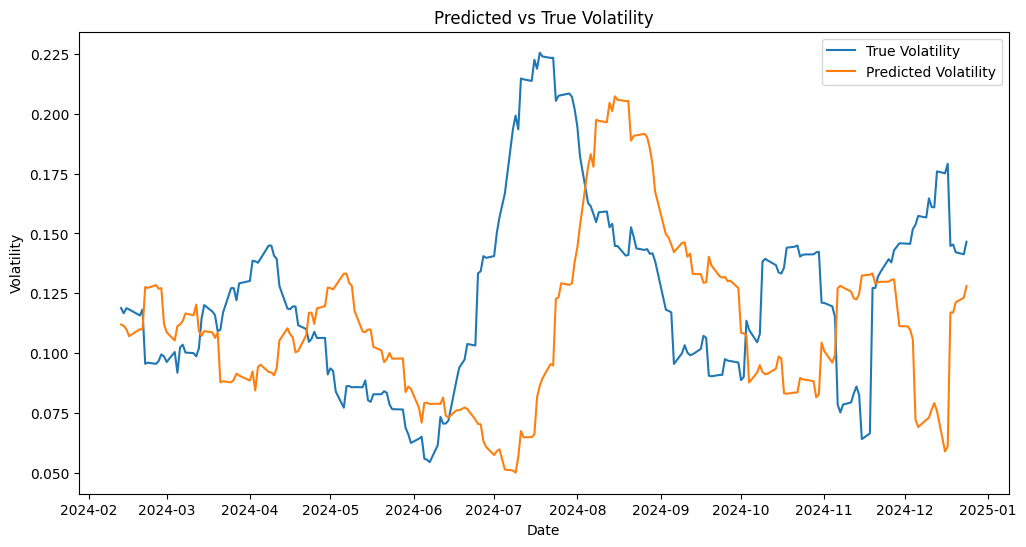

In [18]:
# Fit the best lambda for EWMA on the training set
best_mse = np.inf
best_lambda = 0
for l in np.linspace(0, 1, 100):
    y_pred = l*X_train**2 + (1-l)*df["SP500_Volatility_20d"][:train_size-prediction_horizon]
    mse = ((y_pred - y_train)**2).mean()
    if mse < best_mse:
        best_mse = mse
        best_lambda = l

# Predict the volatility on the test set
y_pred = best_lambda*X_test**2 + (1-best_lambda)*df["SP500_Volatility_20d"][train_size:-prediction_horizon]

# Compute performance metrics
print_metrics_and_plot(y_test, y_pred)

Ca rend bien mais je ne sais pas si c'est vraiment correct car on cherche à prédire la volatilité sur 20 jours sachant qu'on a accès à la volatilité sur 20 jours du jour précédent (il y a donc 19 jours en commun), ce qui explique (je pense) le fait que notre prédiction est toujours "en retard" par rapport à la volatilité calculée.

### GARCH (Generalized Autoregressive Conditional Heteroskedasticity)
#### Utilisation d'un modèle GARCH(1,1) "à la main"

/tmp/ipykernel_6961/211313930.py:11: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



Mean Squared Error: 0.0024
R-squared: -0.6347


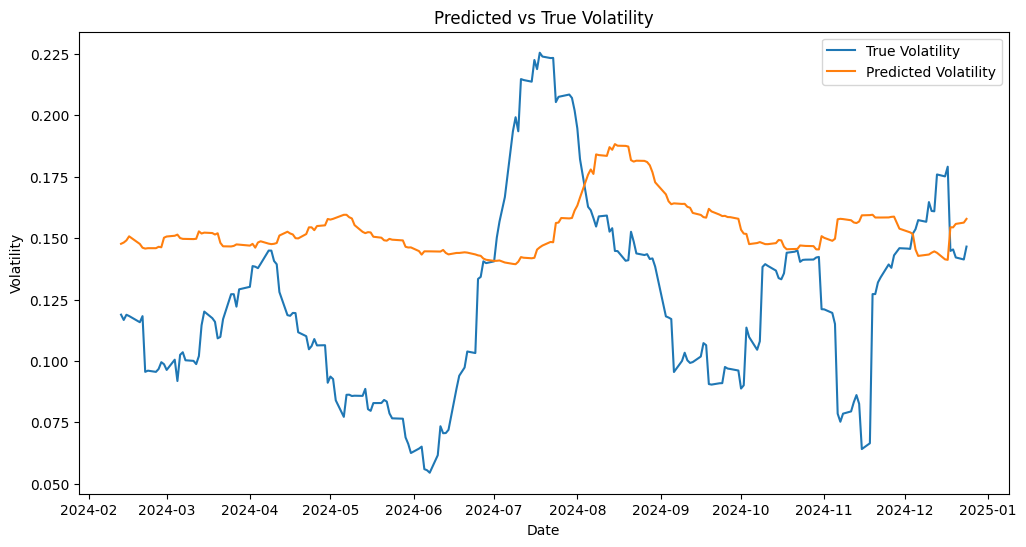

In [19]:
long_term_vol = y_train.mean()

# Fit the best parameters for GARCH(1,1) on the training set
best_mse = np.inf
best_alpha, best_beta, best_gamma = 0, 0, 0
for alpha in np.linspace(0, 1, 10):
    for beta in np.linspace(0, 1, 10):
        for gamma in np.linspace(0, 1, 10):
            sigma2 = np.zeros(X_train.shape[0])
            for i in range(prediction_horizon, X_train.shape[0]):
                sigma2[i] = alpha*long_term_vol + beta*y_train[i-prediction_horizon]**2 + gamma*X_train[i-prediction_horizon]**2
            y_pred = np.sqrt(sigma2)
            mse = ((y_pred - y_train)**2).mean()
            if mse < best_mse:
                best_mse = mse
                best_alpha, best_beta, best_gamma = alpha, beta, gamma


# Predict the volatility on the test set
y_pred = np.zeros(X_test.shape[0])
for i in range(prediction_horizon):
    y_pred[i] = np.sqrt(best_alpha*long_term_vol + best_beta*y_train.iloc[-prediction_horizon+i]**2 + best_gamma*X_train.iloc[-prediction_horizon+i]**2)
for i in range(prediction_horizon, X_test.shape[0]):
    y_pred[i] = np.sqrt(best_alpha*long_term_vol + best_beta*y_test.iloc[i-prediction_horizon]**2 + best_gamma*X_test.iloc[i-prediction_horizon]**2)

# Compute performance metrics
print_metrics_and_plot(y_test, y_pred)

#### Utilisation d'une librairie

Dans cette partie, on ne prédit pas la volatilité mais on calibre un modèle GARCH(1,1) sur l'ensemble des données et on voit ce que ça donne sur les données de test.

Mean Squared Error: 0.0004
R-squared: 0.7459


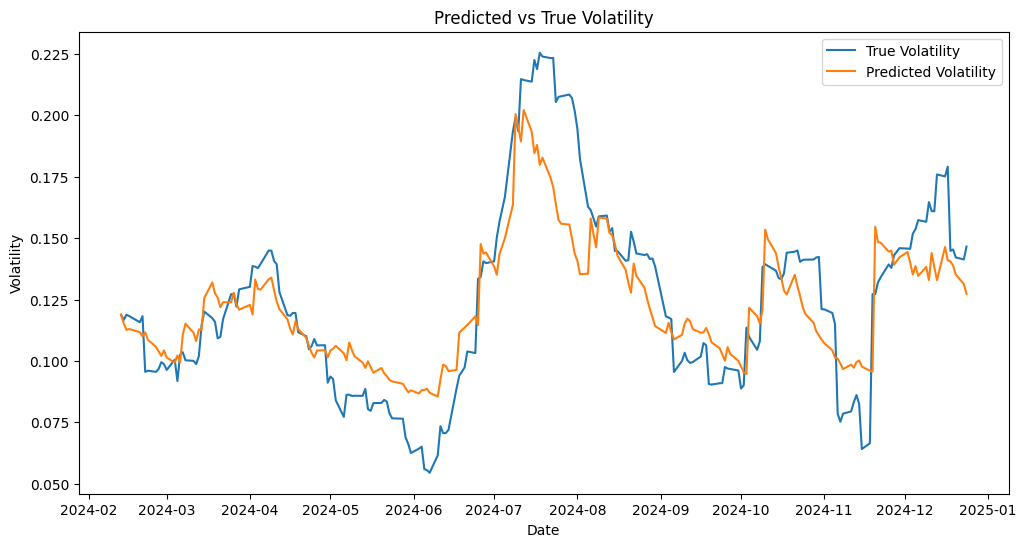

In [20]:
# Step 2: Fit the GARCH model on the training set
model = arch_model(df["SP500_Returns"]*100, vol='GARCH', p=1, q=1)  # This function takes the returns in percentage as input
model_fit = model.fit(disp="off")

# Step 3: Make volatility predictions using the fitted model
y_pred_garch = model_fit.conditional_volatility[-X_test.shape[0]:]
y_pred_garch *= y_test.iloc[0] / y_pred_garch.iloc[0] # I don't know why I have to do this but otherwise the prediction does not appear at the same scale as the true volatility

# Compute performance metrics
print_metrics_and_plot(y_test, y_pred_garch)

Ici, on essaie de faire une prédiction manuelle en prédisant à un horizon de 1 jour sur toute la durée des données de test.

Mean Squared Error: 0.0097
R-squared: -5.5345


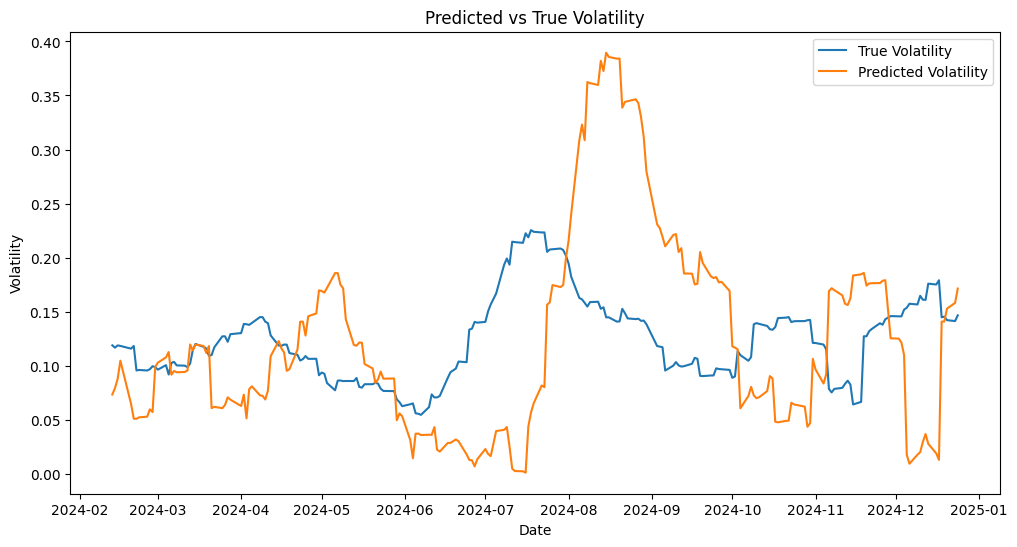

In [21]:
# Step 2: Fit the GARCH model on the training set
model = arch_model(X_train*100, vol='GARCH', p=1, q=1)  # This function takes the returns in percentage as input
model_fit = model.fit(disp="off")

# Initialize an array to store the predictions
y_pred_garch = np.zeros(X_test.shape[0])

# Step 3: Make volatility predictions using the fitted model
for i in range(prediction_horizon):
    new_return = model_fit.forecast(horizon=1).mean.values[-1][0]
    y_pred_garch[i] = np.std([new_return, y_train.iloc[-prediction_horizon+i]]) * np.sqrt(252)
for i in range(prediction_horizon, X_test.shape[0]):
    new_return = model_fit.forecast(horizon=1).mean.values[-1][0]
    y_pred_garch[i] = np.std([new_return, y_test.iloc[i-prediction_horizon]]) * np.sqrt(252)

y_pred_garch *= np.mean(y_test) / np.mean(y_pred_garch) # I don't know why I have to do this but otherwise the prediction does not appear at the same scale as the true volatility

# Compute performance metrics
print_metrics_and_plot(y_test, y_pred_garch)

On reprend le même modèle mais on ajoute les variables exogènes (sauf les returns et la volatilité).

Mean Squared Error: 0.0004
R-squared: 0.7459


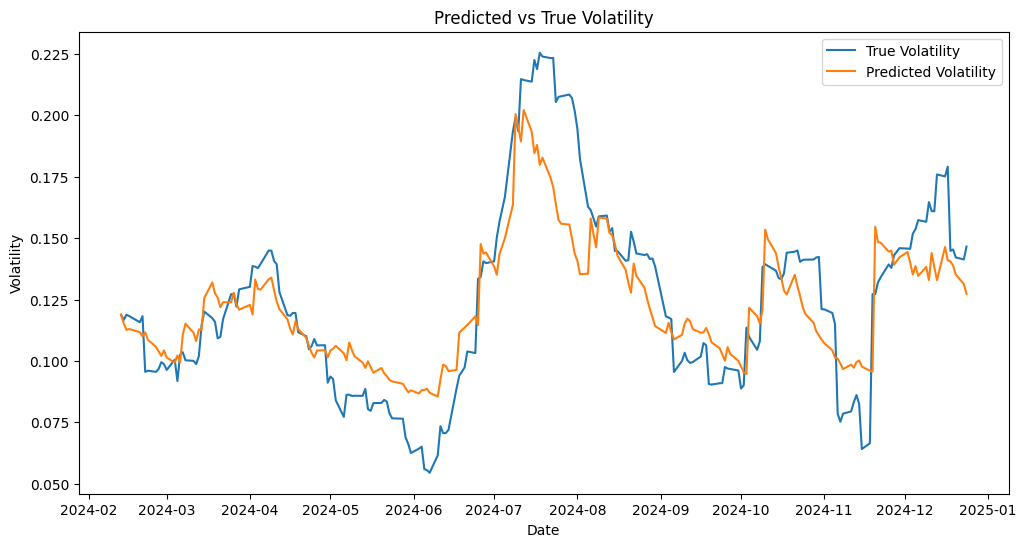

In [22]:
# Step 2: Fit the GARCH model on the training set
model = arch_model(y=df["SP500_Returns"]*100, x=df.drop(columns=["SP500_Returns", "SP500_Volatility_20d"]), vol='GARCH', p=1, q=1)
model_fit = model.fit(disp="off")

# Step 3: Make volatility predictions using the fitted model
y_pred_garch = model_fit.conditional_volatility[-X_test.shape[0]:]
y_pred_garch *= y_test.iloc[0] / y_pred_garch.iloc[0] # I don't know why I have to do this but otherwise the prediction does not appear at the same scale as the true volatility

# Compute performance metrics
print_metrics_and_plot(y_test, y_pred_garch)

Pas d'amélioration

On pourrait éventuellement tester un GARCH(p,q) mais pas sûr que ça donne de meilleurs résultats.

# Machine learning

In [23]:
X_train = df[:train_size-prediction_horizon]
X_test = df[train_size:-prediction_horizon]
y_train = df["SP500_Volatility_20d"][:train_size].shift(-prediction_horizon).dropna()
y_test = df["SP500_Volatility_20d"][train_size:].shift(-prediction_horizon).dropna()

In [24]:
# Check NaN values
print("NaN values in X_train:", X_train.isna().sum().sum())
print("NaN values in X_test:", X_test.isna().sum().sum())
print("NaN values in y_train:", y_train.isna().sum())
print("NaN values in y_test:", y_test.isna().sum())

NaN values in X_train: 0
NaN values in X_test: 0
NaN values in y_train: 0
NaN values in y_test: 0


### Linear regression

Mean Squared Error: 0.0359
R-squared: -23.2437


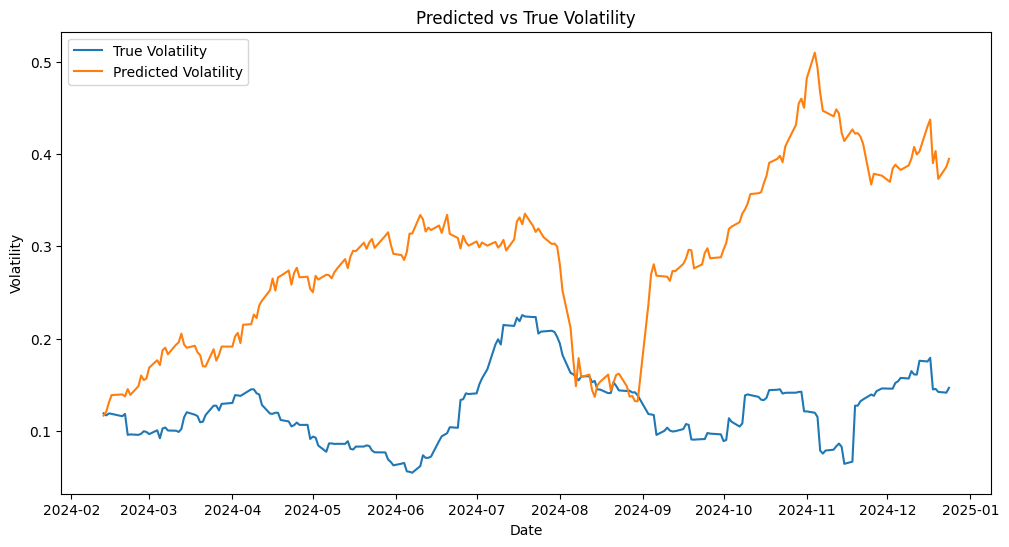

In [25]:
# Initialize the Linear Regression model
lr = LinearRegression()

# Train the model on the training data
lr.fit(X_train, y_train)

# Make predictions on the test data
y_pred = lr.predict(X_test)

# Evaluate the model and plot the results
print_metrics_and_plot(y_test, y_pred)

### Random forest

Mean Squared Error: 0.0018
R-squared: -0.1925


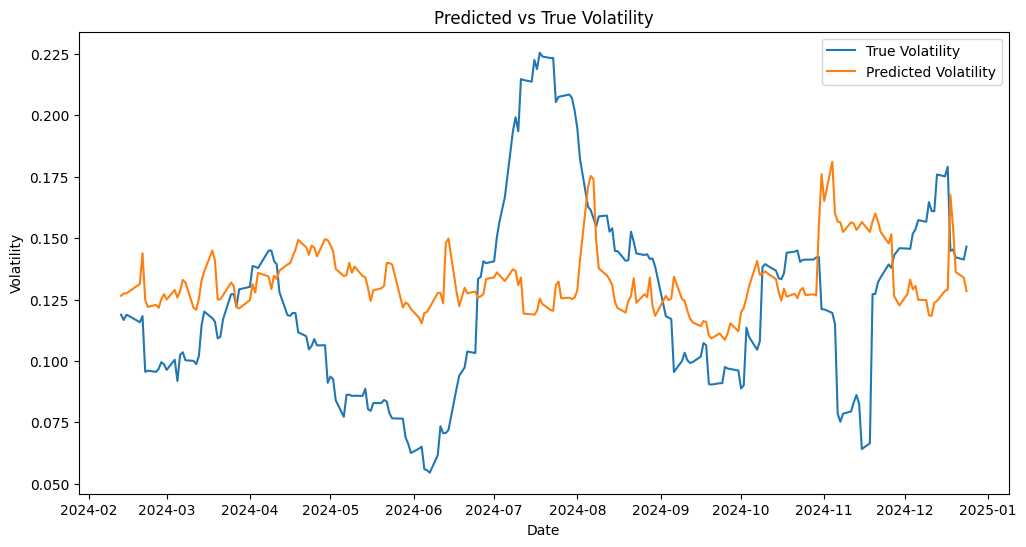

In [26]:
# Initialize the Random Forest Regressor model
rf = RandomForestRegressor(n_estimators=100, random_state=42)  # You can tune hyperparameters

# Train the model on the training data
rf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = rf.predict(X_test)

# Evaluate the model and plot the results
print_metrics_and_plot(y_test, y_pred)

### XGBoost

Mean Squared Error: 0.0020
R-squared: -0.3650


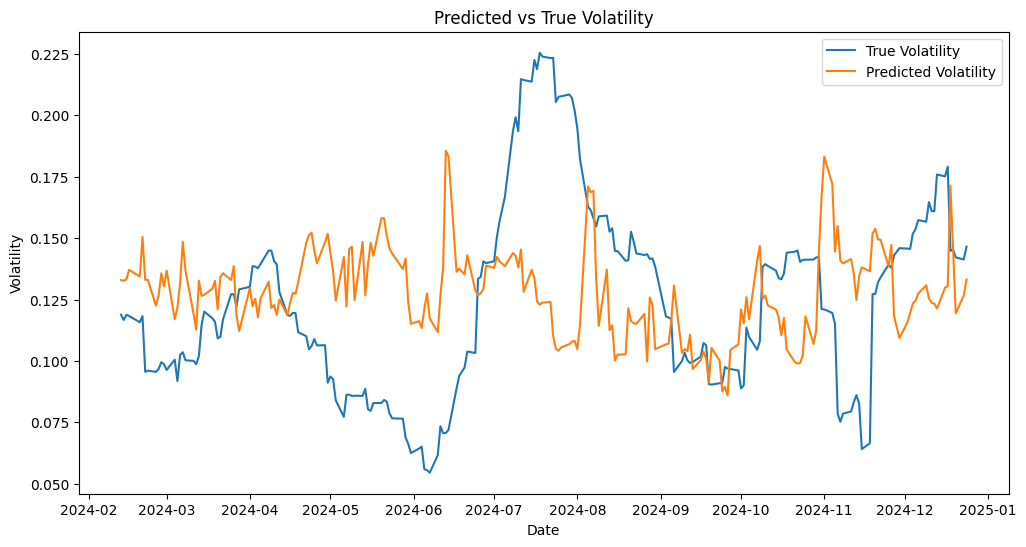

In [27]:
# Initialize the XGBoost Regressor model
xgb = XGBRegressor(n_estimators=100, random_state=42)  # You can tune hyperparameters

# Train the model on the training data
xgb.fit(X_train, y_train)

# Make predictions on the test data
y_pred = xgb.predict(X_test)

# Evaluate the model and plot the results
print_metrics_and_plot(y_test, y_pred)

### SVM

Best hyperparameters: {'C': 1, 'epsilon': 0.05, 'gamma': 0.001}
Mean Squared Error: 0.0028
R-squared: -0.9060


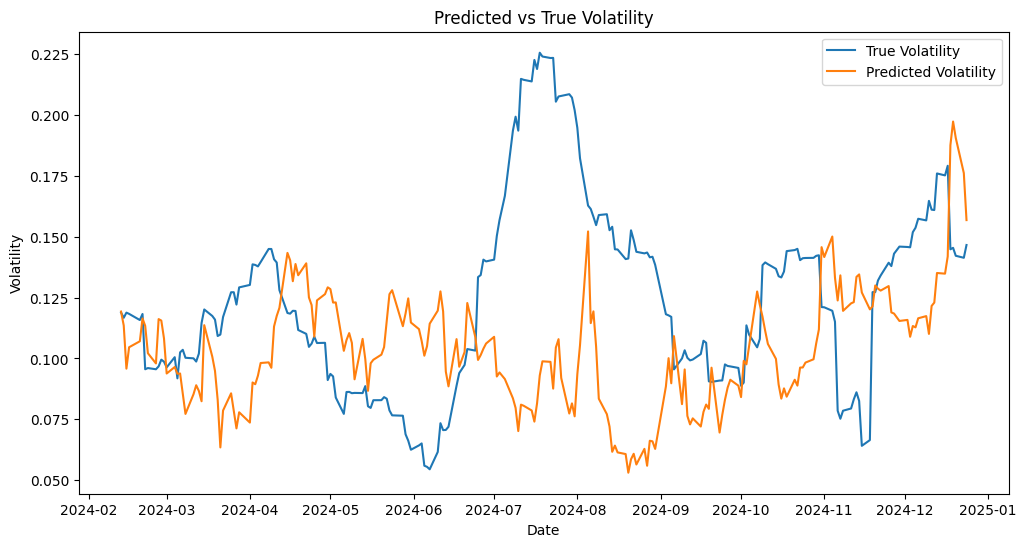

In [28]:
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the Support Vector Regressor model
svr = SVR(kernel="rbf")

# Define a grid of hyperparameters to search
param_grid = {
    'C': [.001, 0.01, 0.1, 1],
    'gamma': [0.01, 0.001, 1e-4],
    'epsilon': [.001, 0.05, 0.1, 0.2]
}

# Use GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(svr, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train_scaled, y_train)

# Print the best hyperparameters
print("Best hyperparameters:", grid_search.best_params_)

# Best model from grid search
best_svr = grid_search.best_estimator_

# Make predictions on the test data
y_pred = best_svr.predict(X_test_scaled)

# Evaluate the model and plot the results
print_metrics_and_plot(y_test, y_pred)

# Deep learning
### RNN (or LSTMs)

In [29]:
# Use RNN to predict the volatility


# Bayesian models
Je sais pas si on peut faire quelque chose par là, avec une modélisation probabiliste/stochastique. 

### Bayesian GARCH model

### Markov switching model

### Gaussian processes

### Stochastic volatility model